# Solving the loan timing problem using Gompertz model implemented using Pyro 

In [71]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro.infer import Predictive

### Loading data and converting into cumulative percentage

Text(0, 0.5, 'Percentage of Cumulative Loans thats Charged-off')

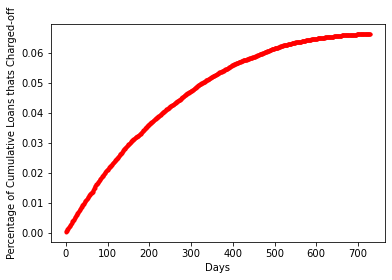

In [72]:
data = pd.read_csv('D:\data\loan_timing.csv')
data = data.rename(columns={'days since origination': 'd_origin', 'days from origination to chargeoff': 'd_chargeoff'})
data_clean = data.dropna() 
d_chargeoff_np = data_clean['d_chargeoff'].to_numpy()
chargeoff = []
for i in range(np.max(d_origin_np)):
    temp_chargeoff = np.where(d_chargeoff_np == i)
    chargeoff.append(np.size(temp_chargeoff[0]))
chargeoff = np.asarray(chargeoff)
percentage = chargeoff*100/50000
percentage_cumsum_np = np.cumsum(percentage)/100
plt.plot(percentage_cumsum_np,'r.')
plt.xlabel('Days')
plt.ylabel('Percentage of Cumulative Loans thats Charged-off')

### Normalizing data

In [73]:
percentage_cumsum = torch.tensor(percentage_cumsum_np, dtype=torch.float)
time = torch.arange(np.size(percentage_cumsum_np))/1095.
time = time.type(torch.FloatTensor)
pyro.set_rng_seed(1)

### Using a Gompertz function to model loan charged-off percentage  
For people unfamiliar with Gompertz function ref to the wikipedia article: https://en.wikipedia.org/wiki/Gompertz_function
For learning more about Pyro ref to https://pyro.ai/, also for linear bayesian regression have a look at https://pyro.ai/examples/bayesian_regression.html.

In [74]:
def model(time, percentage_cumsum):
    L = pyro.sample("L", dist.Normal(0., 10.))
    k = pyro.sample("k", dist.Normal(0., 10.))
    z = pyro.sample("z", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    y = L*torch.exp(-k*torch.exp(-z*time))
    with pyro.plate("data", len(time)):
        pyro.sample("obs", dist.Normal(y, sigma), obs=percentage_cumsum)

In [75]:
# We are using an autoguide for SVI 
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=TraceEnum_ELBO())
num_iters = 2000
pyro.clear_param_store()
losses = []
for i in range(num_iters):
    elbo = svi.step(time, percentage_cumsum)
    losses.append(elbo)
    print(elbo)

-2791.232666015625
-2812.079345703125
-2798.3515625
-2680.02978515625
-2850.5537109375
-2891.988525390625
-2529.665283203125
-2856.527587890625
-2885.220458984375
-2716.6630859375
-2734.32177734375
-2765.5771484375
-2867.277587890625
-2848.21875
-2863.719482421875
-2781.59619140625
-2892.660400390625
-2893.78564453125
-2834.601806640625
-2853.72802734375
-2855.255615234375
-2887.435791015625
-2879.70654296875
-2885.564208984375
-2860.905029296875
-2817.700439453125
-2883.89306640625
-2825.990966796875
-2896.20947265625
-2903.2626953125
-2879.750732421875
-2895.09814453125
-2828.356689453125
-2906.0693359375
-2692.271728515625
-2864.592529296875
-2904.68017578125
-2913.046630859375
-2814.095947265625
-2774.81298828125
-2888.621337890625
-2856.52001953125
-2867.43359375
-2850.85546875
-2865.662109375
-2869.596435546875
-2867.335205078125
-2834.830322265625
-2900.7685546875
-2861.01025390625
-2778.496826171875
-2888.2421875
-2917.56298828125
-2907.045166015625
-2878.262451171875
-2820.591

In [76]:
# Using predictive function provided by Pyro for inference
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
pred = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(time, percentage_cumsum).items()
               if k != "obs"}
k_pred = pred.get('k')
k_pred_mean = np.mean(k_pred, 0)
L_pred = pred.get('L')
L_pred_mean = np.mean(L_pred, 0)
z_pred = pred.get('z')
z_pred_mean = np.mean(z_pred, 0)

Text(0, 0.5, 'Percentage of Cumulative Loans thats Charged-off')

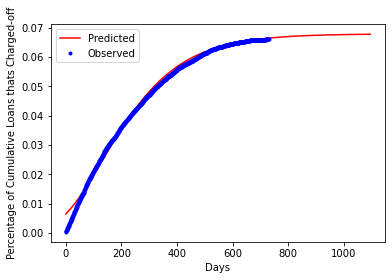

In [77]:
t = np.arange(1095)/1095.
y_pred = L_pred_mean*np.exp(-k_pred_mean*np.exp(-z_pred_mean*t))
plt.plot(np.arange(1095),y_pred,'r',label='Predicted')
plt.plot(np.arange(1095)[:730],percentage_cumsum_np,'b.',label='Observed')
plt.legend(loc="upper left")
plt.xlabel('Days')
plt.ylabel('Percentage of Cumulative Loans thats Charged-off')

In [78]:
y_pred[-1]*100

6.784393652307773

### The fraction of loans that will have charged off at the end of the repayment period is 6.78%. 